# Mode-Turbulence Coupling: Numerical Analysis
# M = 10^4, < Delta_tau > = pi, K = 1, eta M^2 = 0.01
# nonlinear run: N0 = 1, eqmean = 0
# Vary damping constants

In [23]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as interpolate

n_bins = 200

axis_font = {'size':'30'}
title_font = {'size':'40'}

# flattens nested arrays into one dimensional arrays
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

# root mean square
def Funavg(B):
    if len(B) == 0:
        return 0
    else:
        return sum(B)/len(B)
    
def FunplotAmp(amptime, Amp):
    plt.figure(figsize=(40,10))
    plt.plot(amptime, Amp, 'k')
    plt.title('Amplitude of the Mode', **title_font)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('Amplitude', **axis_font)
    plt.tight_layout()
    plt.show()

## Physical Parameters

In [24]:
# eta * Ma ^2 = 0.01
Ma = 0.01 ** (1/2)
K = 1
eta = 1

## Functions of Ma

In [25]:
meandeltaT = np.pi

# variables for generating F2, H, and G1
stdF2 = eta * Ma**2
limitY2 = eta 
eqmean = 0

D = 0

## Calculation parameters

In [26]:
L = 1
M = 10**5
M_short = 100
N = 1
m = 10**2

J = 100
dTau= 2 * np.pi / J

Tr = K * meandeltaT

Tmax = 2 * np.pi * M

## Initial Conditions

In [27]:
initial_AT = 0
initial_dAdT = 0

### Functions

In [28]:
def fundeltaT(n_bins, M, dTau):
    Tturb = [0]
    deltaT = []
    
    # generate a rayleigh distribution from which to pick values for deltaT from
    rayleigh = np.random.rayleigh(meandeltaT, M)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    
    for i in range(M):
        # picks a random value from the rayleigh distribution
        r = np.random.rand(1)
        deltaTtemp = inv_cdf(r)
        
        # rounds deltaTtemp up or down to be an interger multiple of dTau
        if (deltaTtemp % dTau < 0.005):
            deltaTtemp2 = deltaTtemp - (deltaTtemp % dTau)
        else:
            deltaTtemp2 = deltaTtemp + dTau - (deltaTtemp % dTau)
            
        deltaT.append(deltaTtemp2[0])
        Tturb.append(deltaTtemp2 + Tturb[i])
        
    Tturb.pop(-1)
    Tturb.pop(-1)
    return deltaT, Tturb

### F_k Function

In [29]:
# generating F2, G1
def funF_k(std, limit, deltaT, eqmean):
    F_k =[]
    y1 = 0
    
    for i in range(len(deltaT) - 1):
        
        # Tn is halfway through the eddy
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = eqmean + math.exp(-Tn / Tr) * (y1 - eqmean)
        
        # y1 is chosen from markov conditional probability function
        # put limit on y1
            # set y1 > limitY1 so that while loop only ends when y1 < limitY1
        y1 = limit + 1
        while abs(y1) > limit:
            y1 = np.random.normal(meant, stdevt, 2)[0]
        # loops through each eddy
        for j in np.linspace(0, deltaT[i], int(deltaT[i] / dTau)):
            x = j / deltaT[i]
            if j == deltaT[i]:
                pass
            else:
                F_k.append(16 * y1 * x**2 * (1 - x)**2)
        
    return F_k

# generating F1
def fundHdt(std, limit, deltaT, eqmean):
    dHdt =[]
    y1 = 0

    for i in range(len(deltaT) - 1):
        
        # Tn is halfway through the eddy
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = eqmean + math.exp(-Tn / Tr) * (y1 - eqmean)
        
        # y1 is chosen from markov conditional probability function
        # put limit on y1
            # set y1 > limitY1 so that while loop only ends when y1 < limitY1
        y1 = limit + 1
        while abs(y1) > limit:
            y1 = np.random.normal(meant, stdevt, 2)[0]
        
        # loops through each eddy
        for j in np.linspace(0, deltaT[i], int(deltaT[i] / dTau)):
            x = j / deltaT[i]
            if j == deltaT[i]:
                pass
            else:
                # calculated the derivative of H = 16 * y1 * x**2 * (1 - x)**2
                dHdt.append(1 / deltaT[i] * 32 * y1 * x * (2 * x**2 - 3 * x + 1))
        
    return dHdt

def funNLAmp(F1, F2, G1, dTau, A, dAdt, N0, N1, D):
    # huen's method
    # u = dA/dt
    
    Amp = [A]
    t = 0.0
    amptime = [t]
    u = dAdt
    
    for i in range(0, int(len(F1))-2):
        m1 = u
        k1 = - ((D + F1[i]) * u ) - ( 1 + G1[i] ) * A  - (N0 + N1[i]) * A**2 + F2[i]
        m2 = u + dTau * k1
        A_2 = A + dTau * m1
        u_2 = m2
        k2 = -((D + F1[i + 1]) * u_2 ) - ( 1 + G1[i + 1] ) * A_2 - (N0 + N1[i+1]) * A_2**2 + F2[i + 1]
        m2 = u + dTau * k2
        t = t + dTau
        A = A + (dTau / 2) * (m1 + m2)
        u = u + (dTau / 2) * (k1 + k2)
        Amp.append(A)
        amptime.append(t)
        if math.isnan(A):
            break
        

    Amp = Amp[:-1]
    amptime = amptime[:-1]
    
    return Amp, amptime

def funEnergy(Amp, amptime, N0, N1):
    E = []
    A = []
    time = []
    
    F2dAdT = []
    Term1 = []
    
    for i in range(1, len(Amp)-1):
        # dA/dT
        dAdT = (Amp[i+1] - Amp[i-1]) / (amptime[i+1] - amptime[i-1])
        
        F2dAdT.append(F2[i] * dAdT)
        
        E.append( 1/2 * dAdT**2 + 1/2 * Amp[i]**2 + 1/3 * N0 * Amp[i]**3 )
        time.append(amptime[i])
        A.append(Amp[i])
        
        # find max value of A at max time T
        if math.isnan(Amp[i+1]) or abs(Amp[i+1]) > 1:
            break
    return E, time, A, F2dAdT

# root mean square
def FunRMS(B):
    sqr = [a**2 for a in B]
    avg = sum(sqr)/len(sqr)
    return avg**(1/2)

def split(E, num):
    E_avg = []
    
    i = 1
    group = int(len(time)/num)
    
    for eddy in range(num):
        
        # E segment contains the energy values during a specific eddy
        E_segment = []

        while i < len(time) - 1:
            
            #find values within that time segment
            if time[i] <= time[(eddy + 1)*group]:
                E_segment.append(E[i])
                
                i+=1
                
            else:
                # breaks the while loop if the time is outside the time segment 
                # and moves to the next time segment
                break 
        
        # compute average value of E during each segment and round to 7 digits
        E_avg.append(round(Funavg(E_segment), 7))

    return E_avg

In [30]:
def Funplots(t, E, A):
    fig, axs = plt.subplots(2, 1, figsize=(40,20))
    # Remove horizontal space between axes
    fig.subplots_adjust(hspace=0) 

    # Plot each graph, and manually set the y tick values
    axs[0].plot(t, A, 'k')
    axs[0].set_ylabel('A', **axis_font)
    axs[0].set_xlabel('T', **axis_font)
    axs[0].tick_params(axis = 'both', labelsize = 15)

    axs[1].plot(t, E, 'k')
    axs[1].set_ylabel('E', **axis_font)
    axs[1].set_xlabel('T', **axis_font)
    axs[1].tick_params(axis = 'both', labelsize = 15)
    axs[1].tick_params(axis = 'both', labelsize = 15)
    
    plt.show()

## deltaT, F1, F2, G1

In [31]:
deltaT, Tturb = fundeltaT(n_bins, M, dTau)

# generate F1, F2, G1
F1 = fundHdt(stdF2, limitY2, deltaT, eqmean)
F2 = funF_k(stdF2, limitY2, deltaT, eqmean)
G1 = funF_k(stdF2, limitY2, deltaT, eqmean)

In [32]:
N1 = funF_k(stdF2, limitY2, deltaT, eqmean)

# D = 0

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


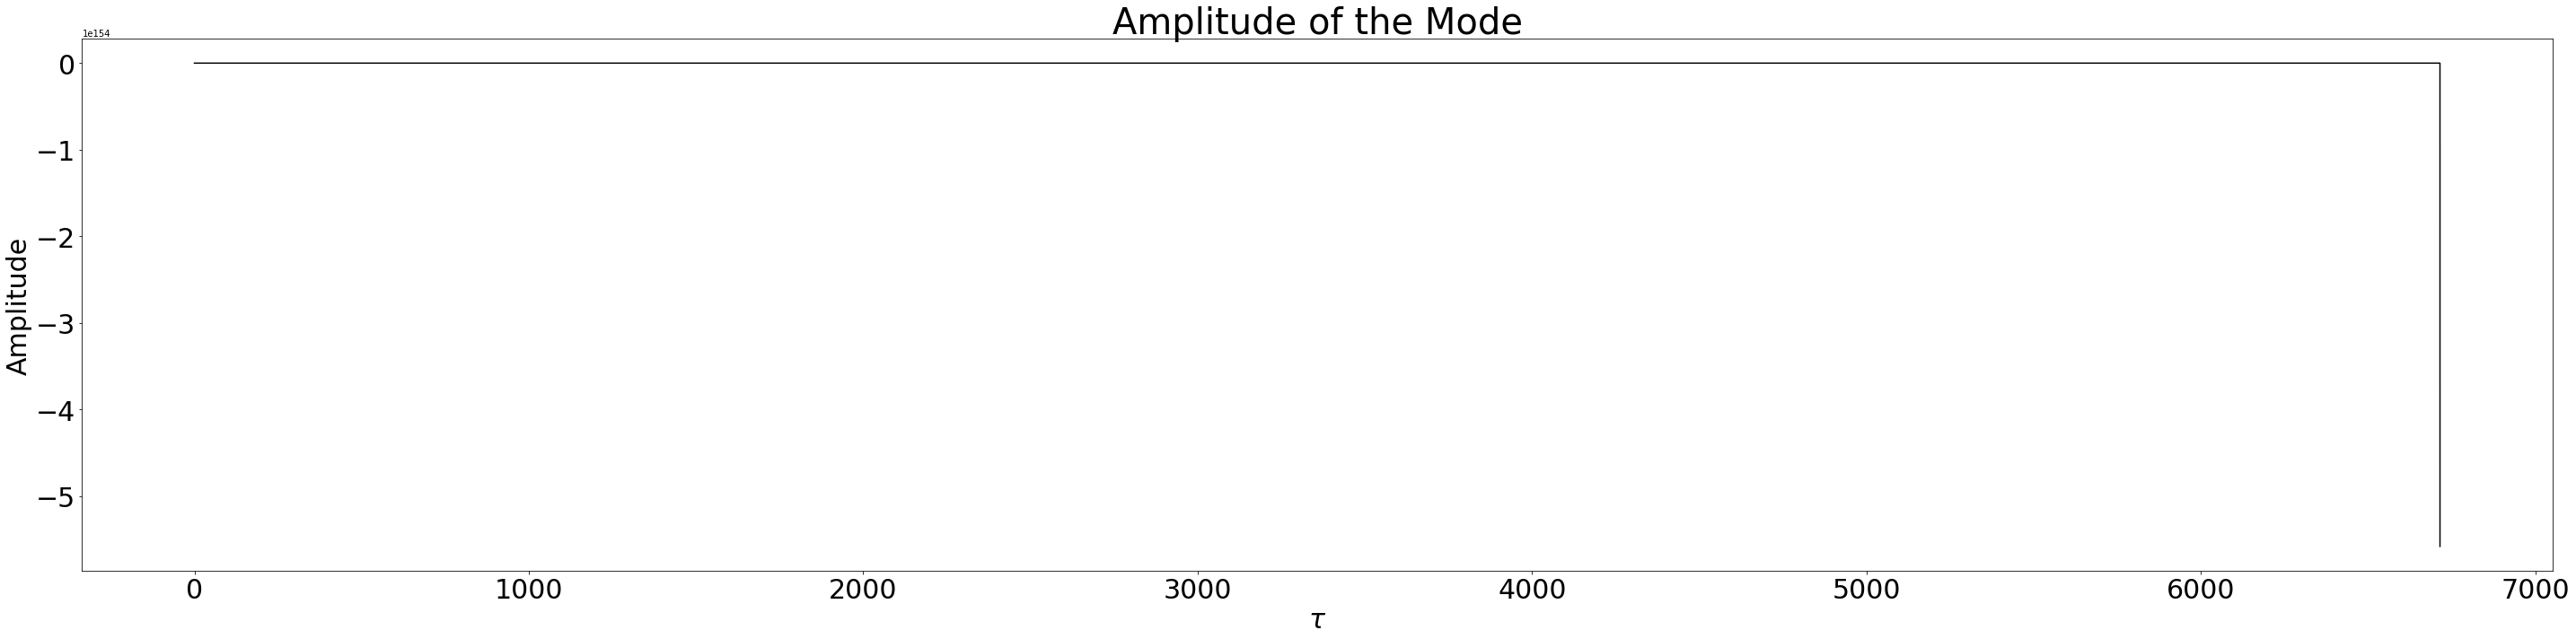

In [33]:
D = 0
N0 = 1

Amp, amptime = funNLAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT, N0, N1, D)

FunplotAmp(amptime, Amp)

### Before blowout

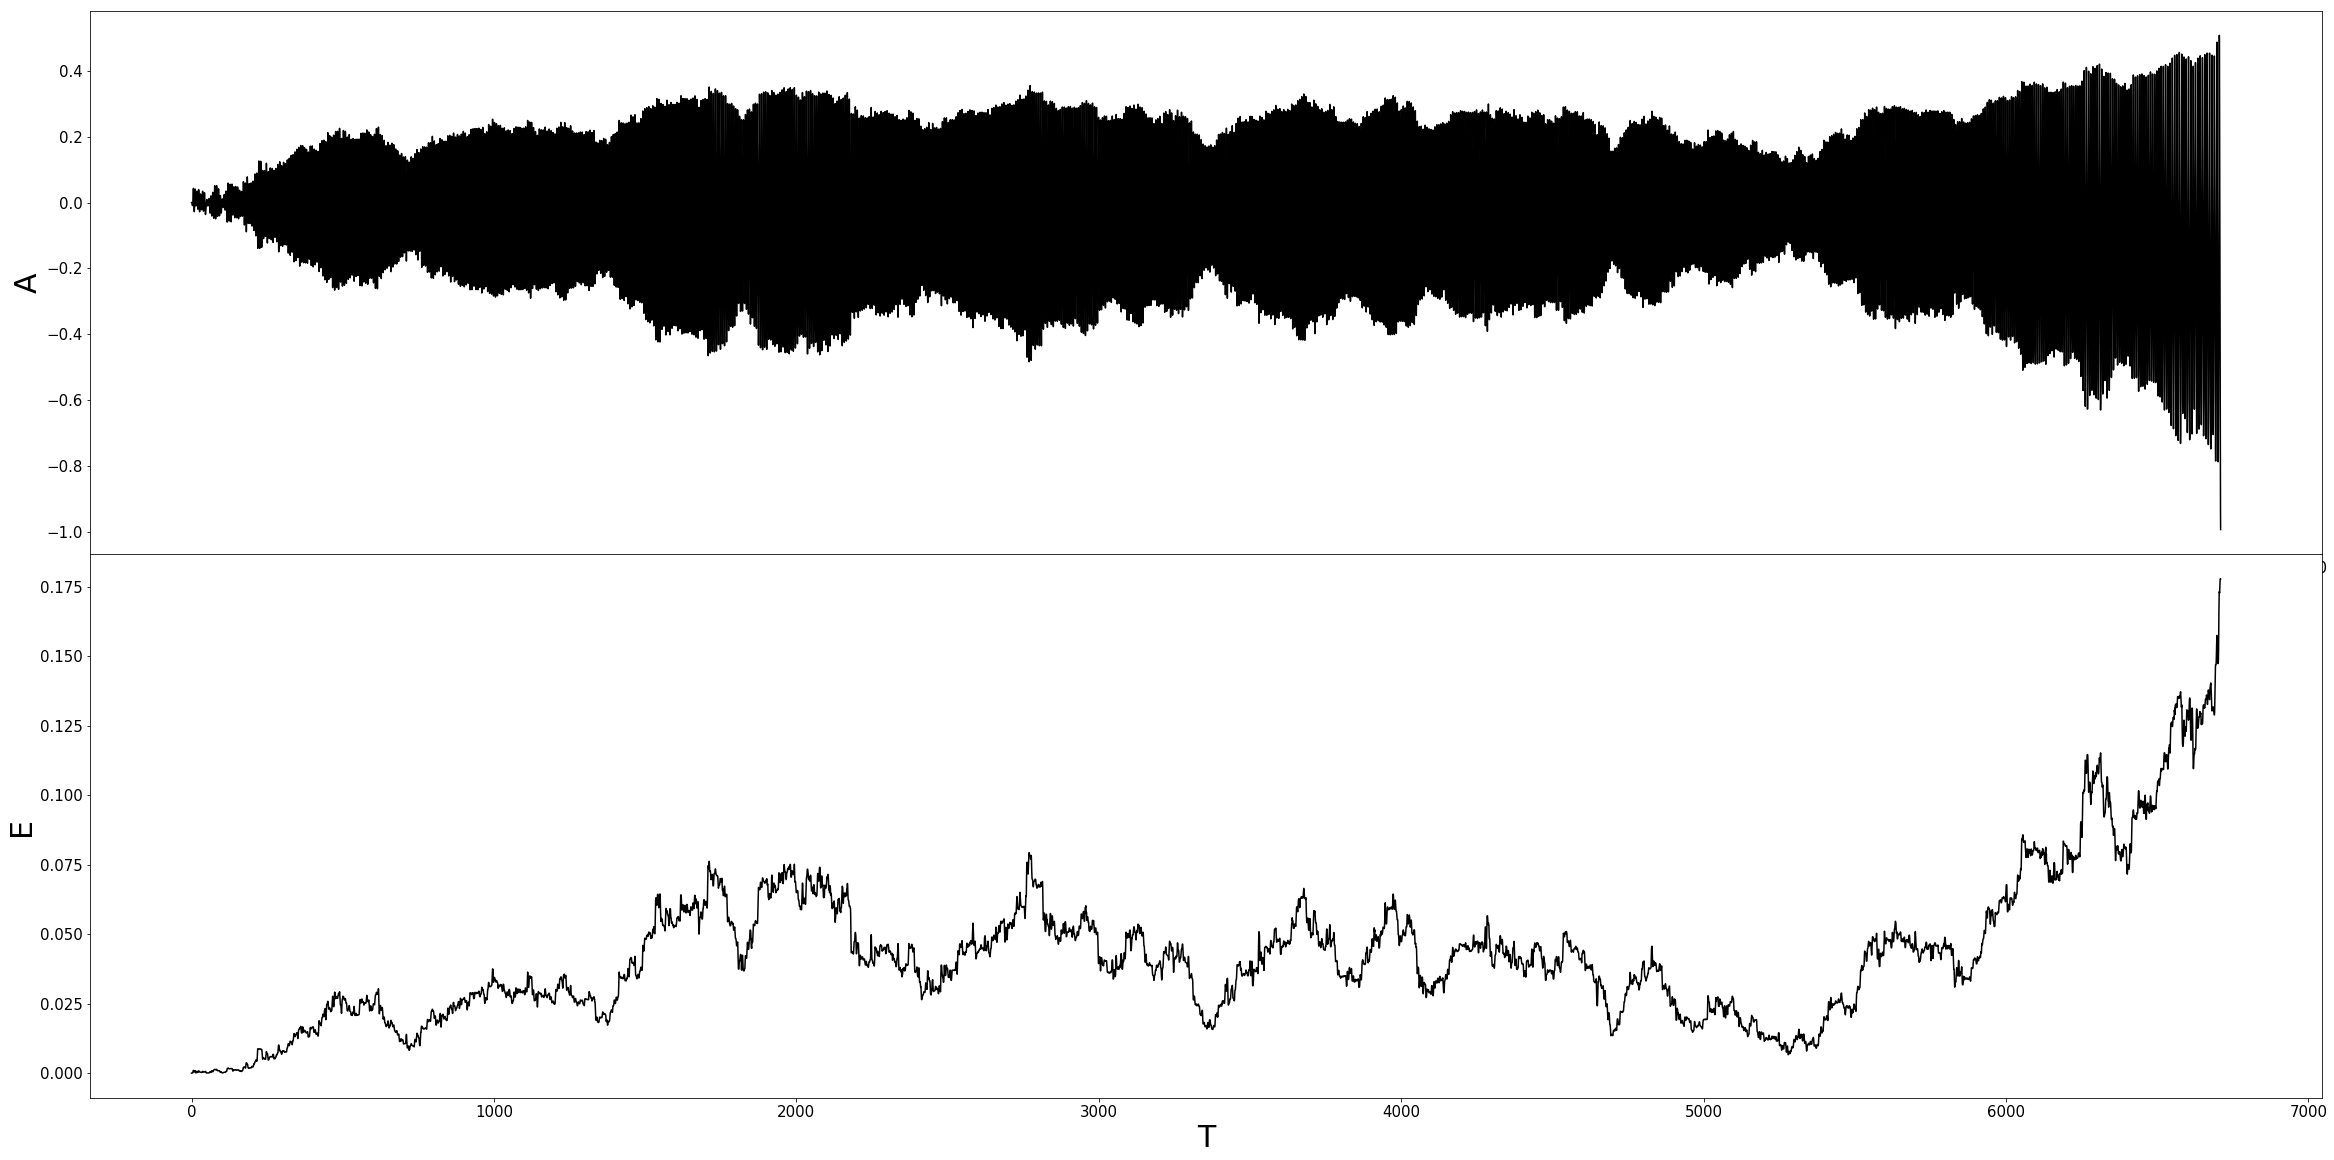

In [34]:
E, time, A, F2dAdT = funEnergy(Amp, amptime, N0, N1)

Eavg = split(E, 40)

Funplots(time, E, A)

In [35]:
print("E_max = ",  max(E))
print("1/(6N0^2) = " , 1/(6*N0**2))

print("\n")

print("D_0 = ", D)
print("2 N_0^2 <F_2 dA/dT >", 2 * N0**2 * Funavg(F2dAdT))

print("\n")

print("Tau_b = ", time[-1])
print("1/(N_0^2 etaMa^2) = ", 1 / (N0**2 * eta * Ma **2 ))
print("Tau_b = ", time[-1] * (N0**2 * eta * Ma **2 ) , "* 1/(N_0^2 etaMa^2)" )

E_max =  0.17783187397933345
1/(6N0^2) =  0.16666666666666666


D_0 =  0
2 N_0^2 <F_2 dA/dT > 5.190265958326901e-05


Tau_b =  6710.064916940205
1/(N_0^2 etaMa^2) =  99.99999999999999
Tau_b =  67.10064916940206 * 1/(N_0^2 etaMa^2)


# D = 0.3

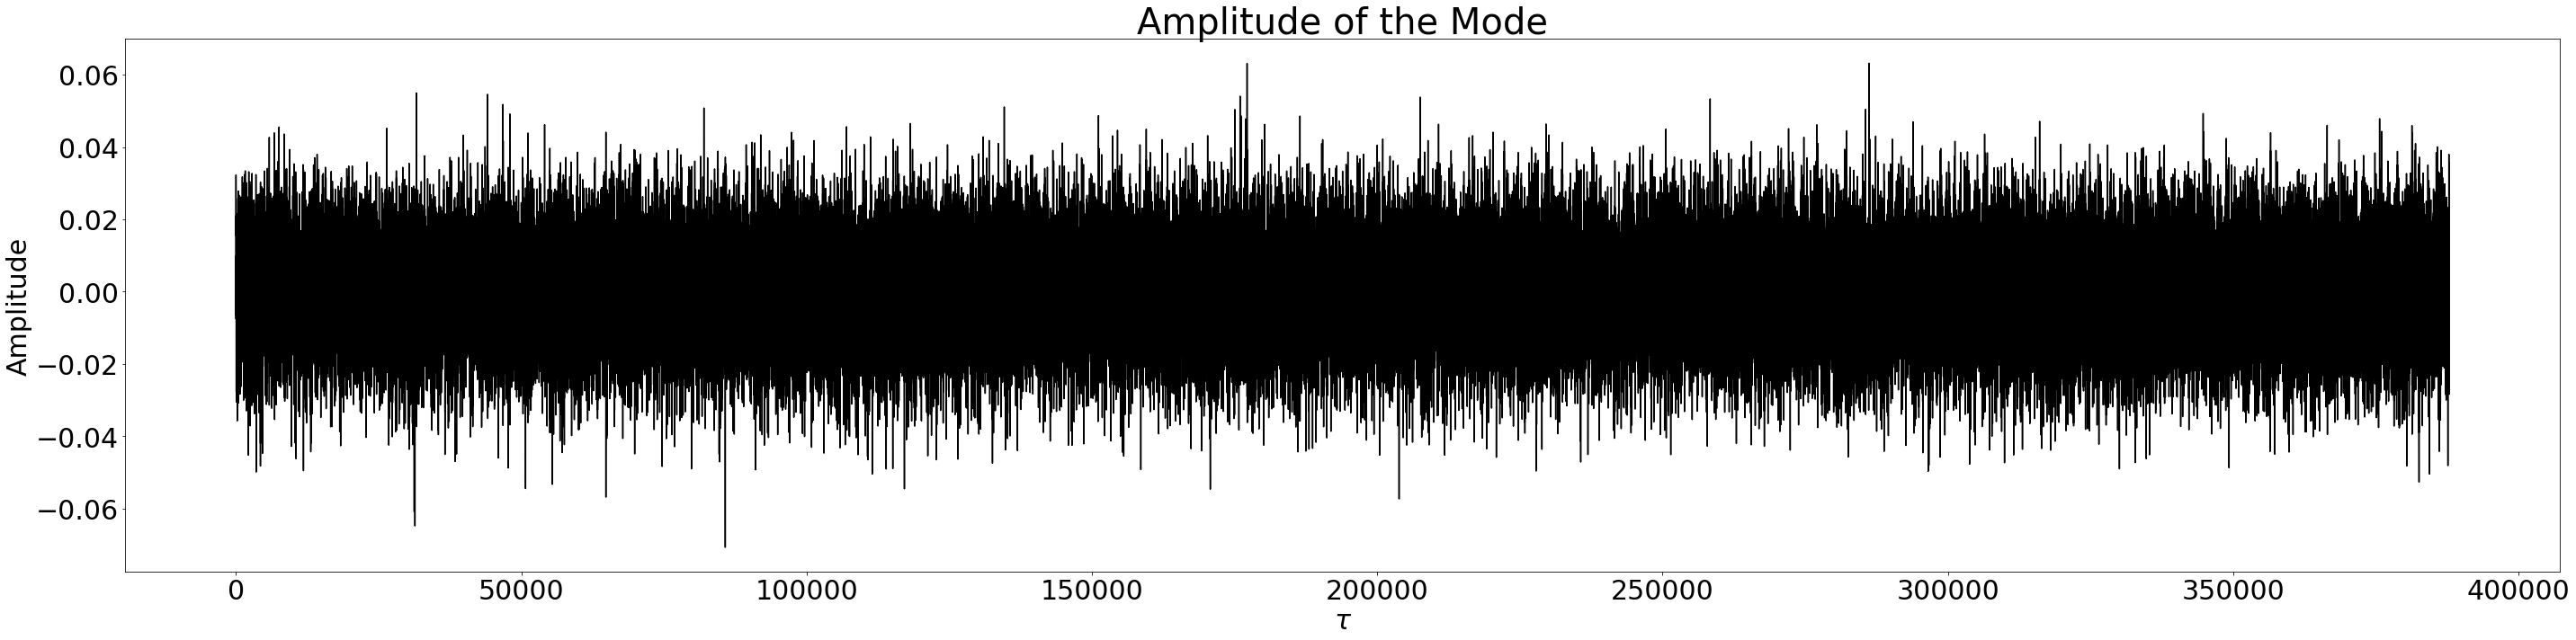

In [36]:
D = 0.3
N0 = 1

Amp, amptime = funNLAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT, N0, N1, D)

FunplotAmp(amptime, Amp)

### Before blowout

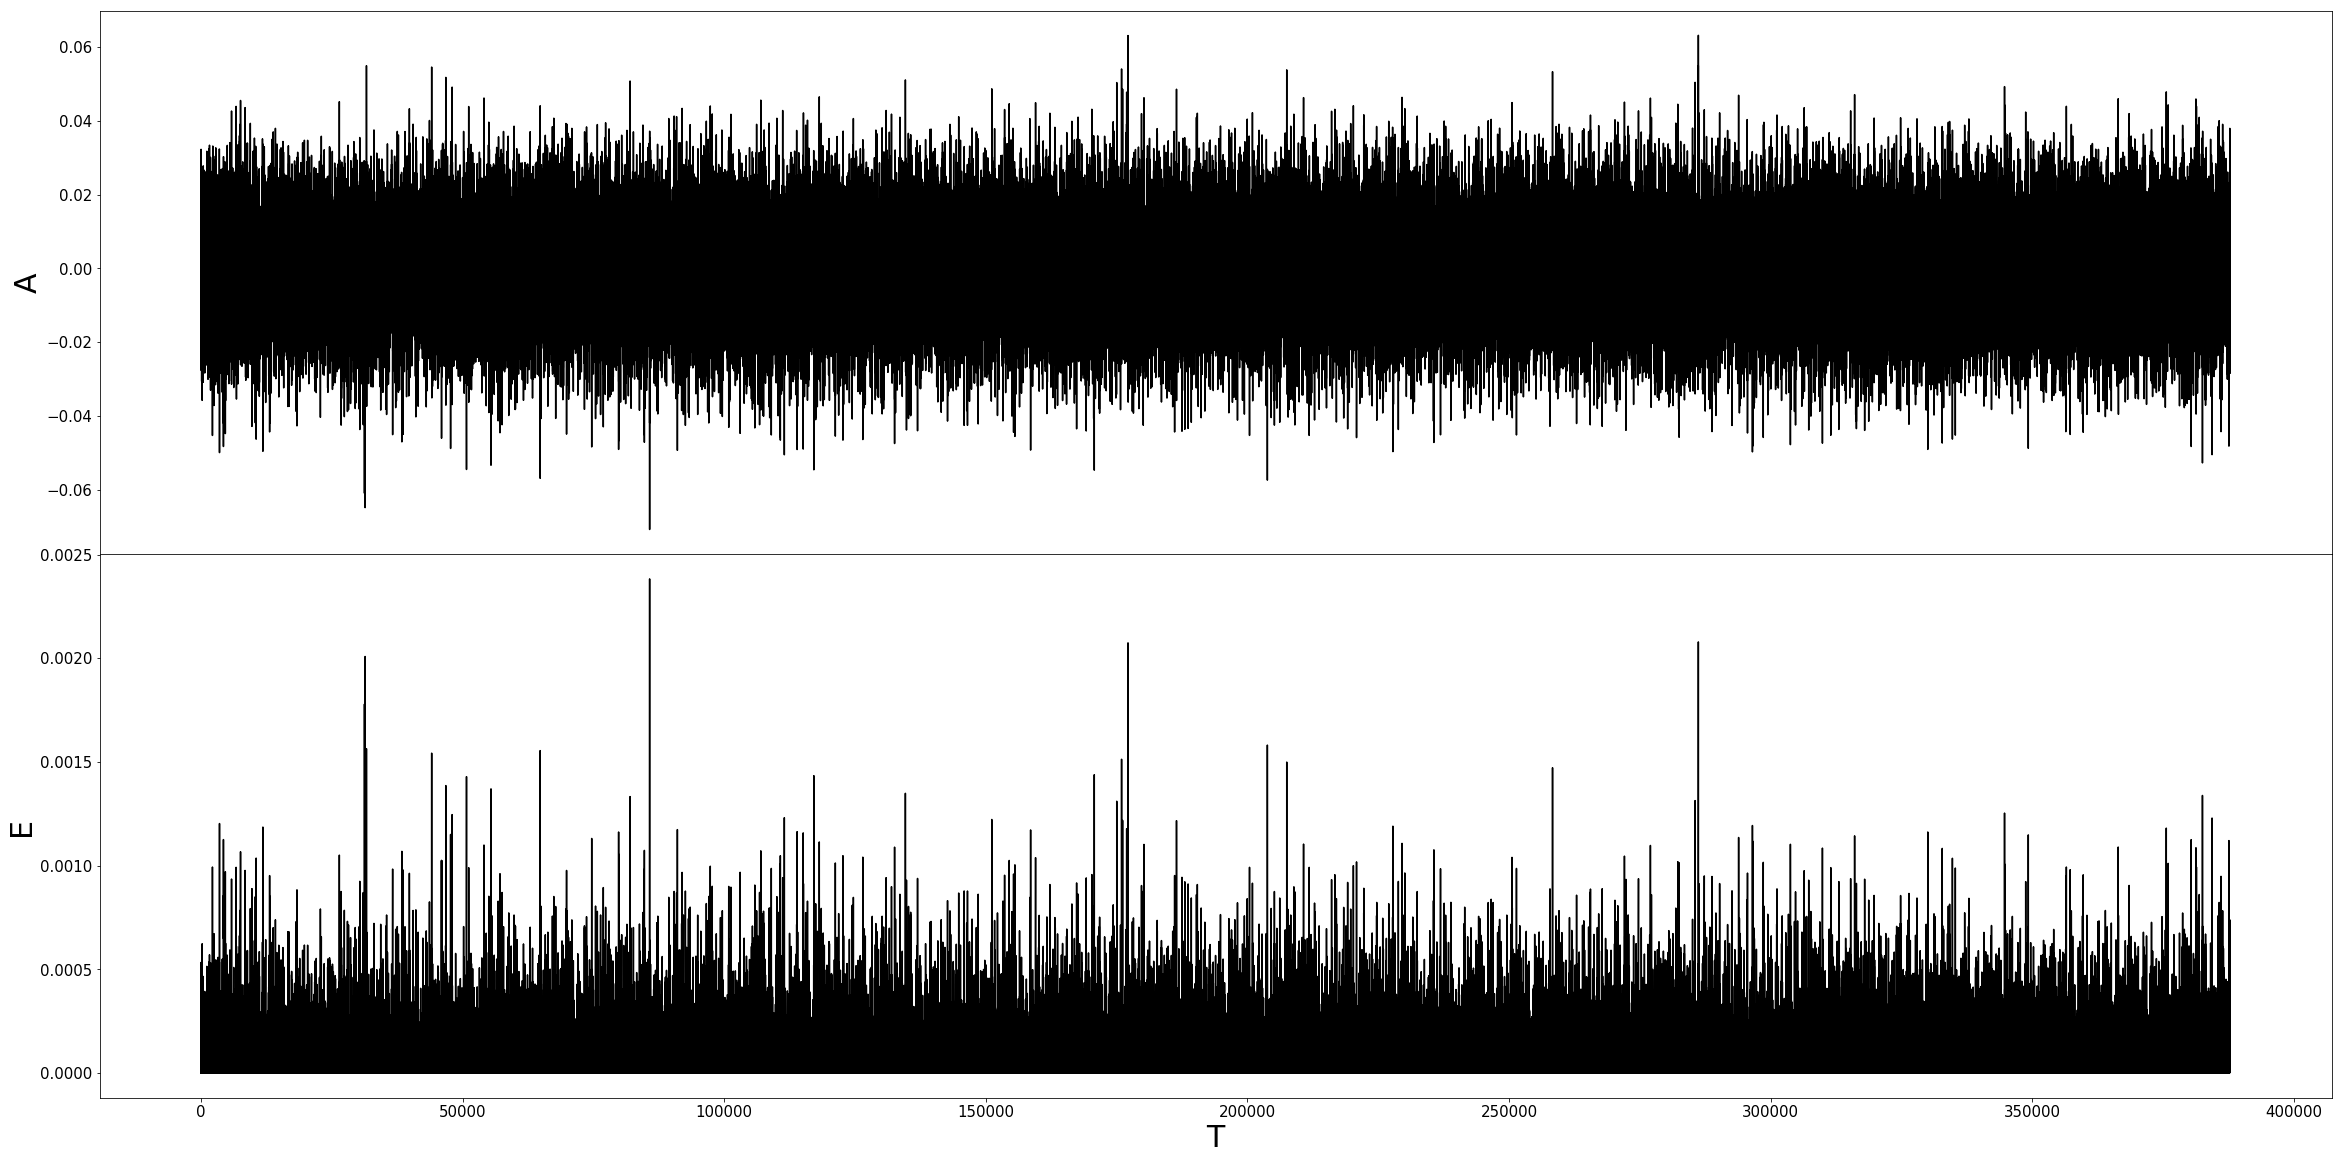

In [37]:
E, time, A, F2dAdT = funEnergy(Amp, amptime, N0, N1)

Eavg = split(E, 40)

Funplots(time, E, A)

In [38]:
print("E_max = ",  max(E))
print("1/(6N0^2) = " , 1/(6*N0**2))

print("\n")

print("D_0 = ", D)
print("2 N_0^2 <F_2 dA/dT >", 2 * N0**2 * Funavg(F2dAdT))

print("\n")

print("Tau_b = ", time[-1])
print("1/(N_0^2 etaMa^2) = ", 1 / (N0**2 * eta * Ma **2 ))
print("Tau_b = ", time[-1] * (N0**2 * eta * Ma **2 ) , "* 1/(N_0^2 etaMa^2)" )

E_max =  0.00238331006462829
1/(6N0^2) =  0.16666666666666666


D_0 =  0.3
2 N_0^2 <F_2 dA/dT > 3.247248368534957e-05


Tau_b =  387843.6873893126
1/(N_0^2 etaMa^2) =  99.99999999999999
Tau_b =  3878.4368738931266 * 1/(N_0^2 etaMa^2)


# D = -0.3

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


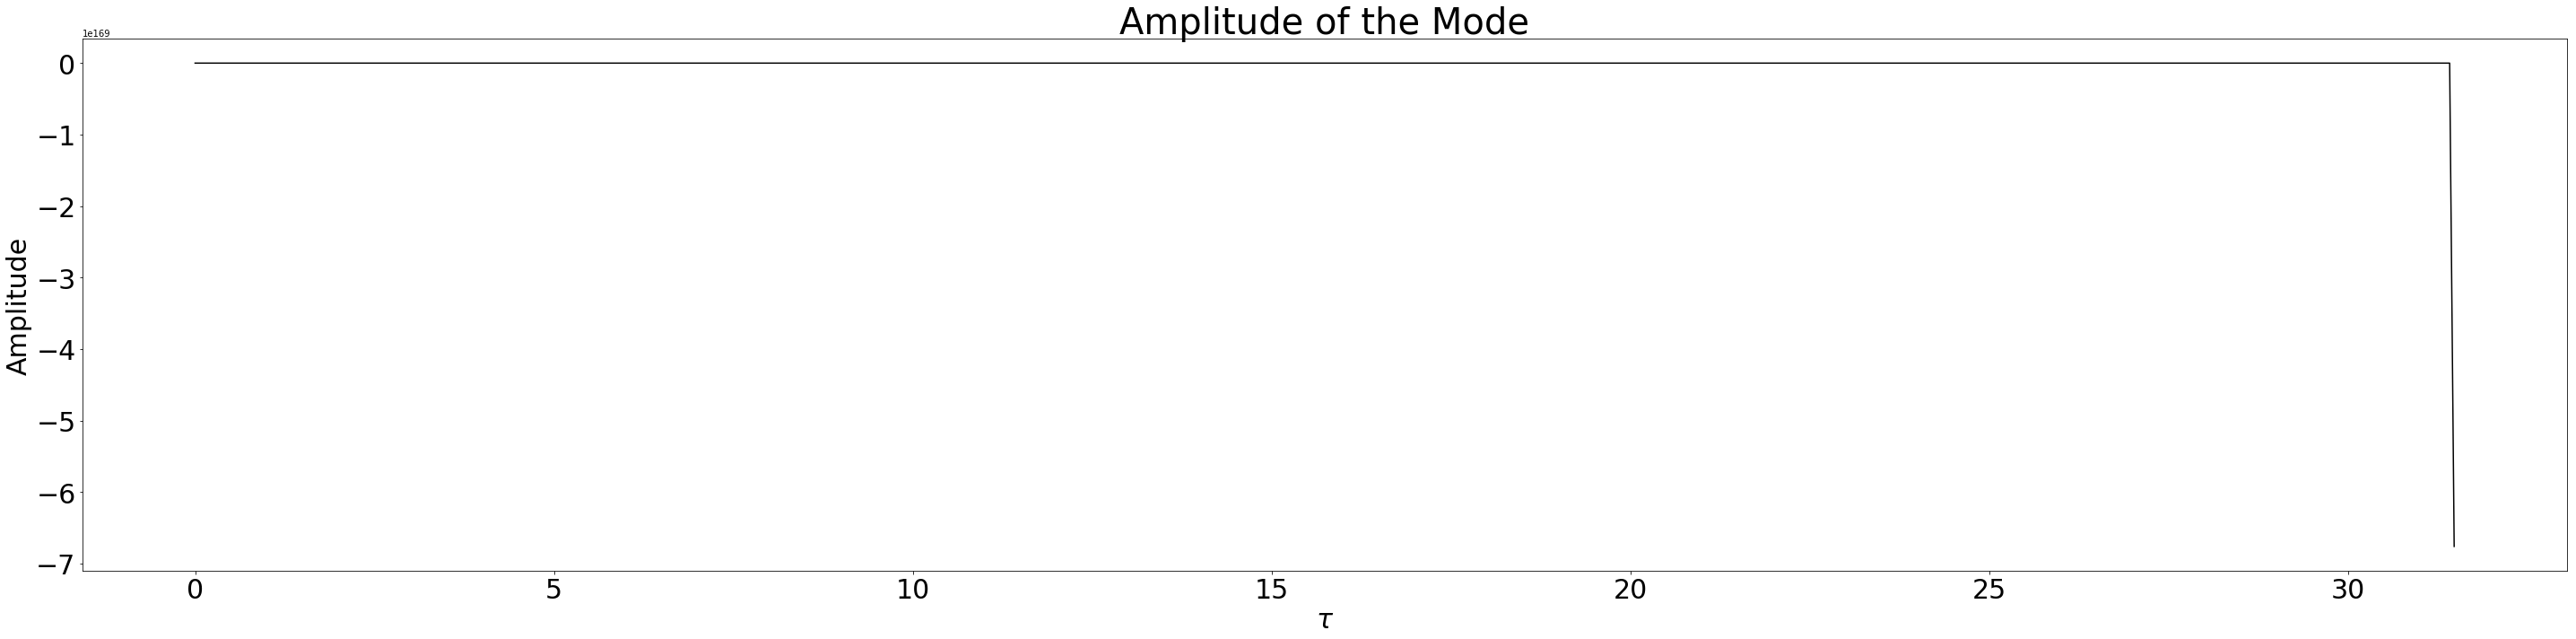

In [39]:
D = -0.3
N0 = 1

Amp, amptime = funNLAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT, N0, N1, D)

FunplotAmp(amptime, Amp)

### Before blowout

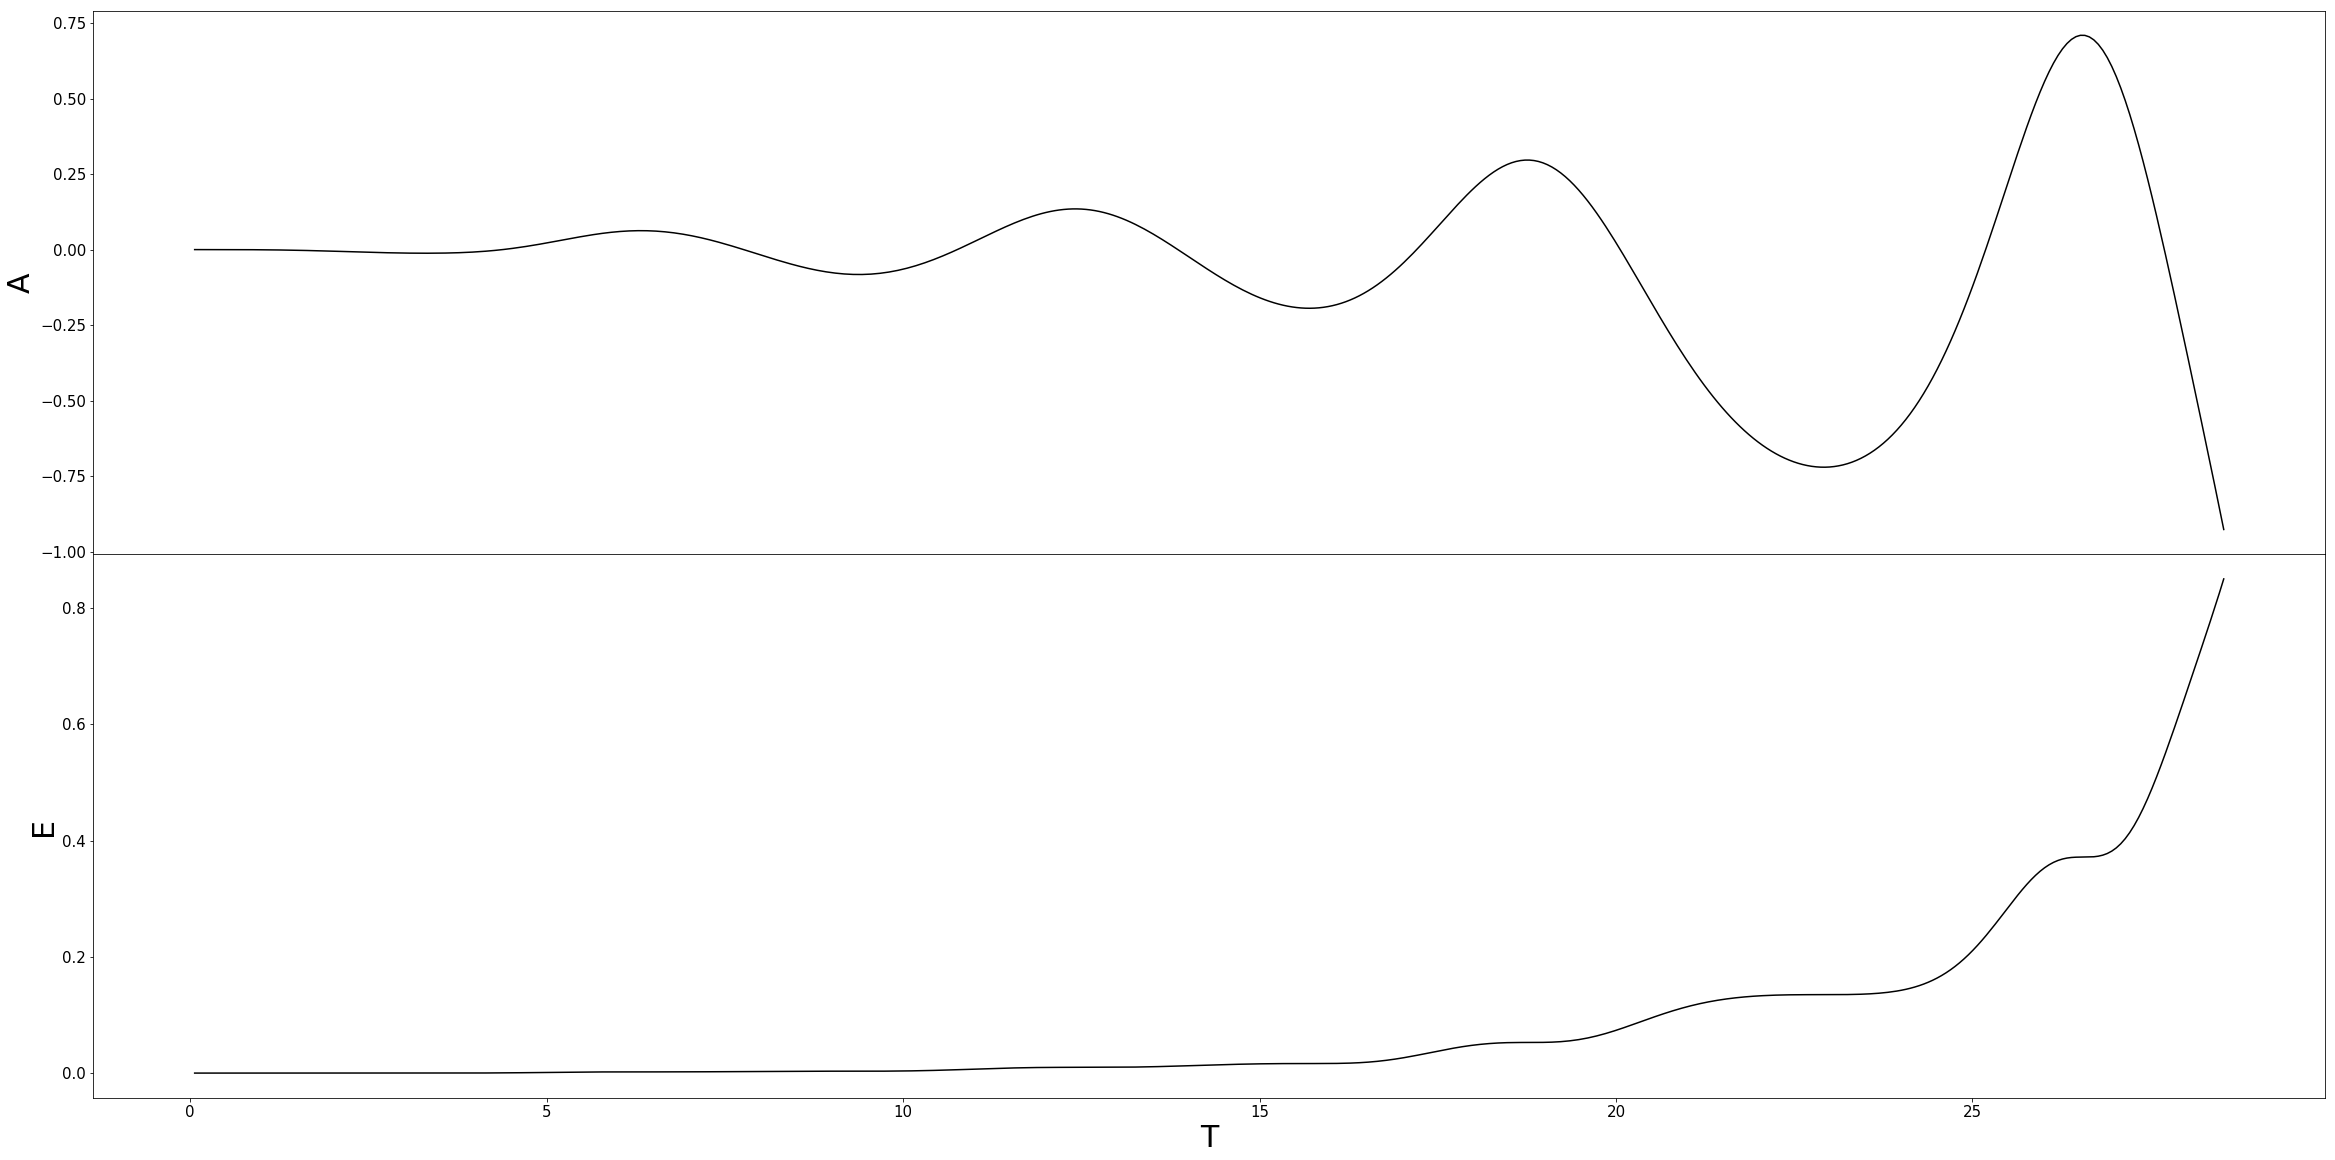

In [40]:
E, time, A, F2dAdT = funEnergy(Amp, amptime, N0, N1)

Eavg = split(E, 40)

Funplots(time, E, A)

In [41]:
print("E_max = ",  max(E))
print("1/(6N0^2) = " , 1/(6*N0**2))

print("\n")

print("D_0 = ", D)
print("2 N_0^2 <F_2 dA/dT >", 2 * N0**2 * Funavg(F2dAdT))

print("\n")

print("Tau_b = ", time[-1])
print("1/(N_0^2 etaMa^2) = ", 1 / (N0**2 * eta * Ma **2 ))
print("Tau_b = ", time[-1] * (N0**2 * eta * Ma **2 ) , "* 1/(N_0^2 etaMa^2)" )

E_max =  0.850265781090874
1/(6N0^2) =  0.16666666666666666


D_0 =  -0.3
2 N_0^2 <F_2 dA/dT > -3.077541265009033e-05


Tau_b =  28.52566129459519
1/(N_0^2 etaMa^2) =  99.99999999999999
Tau_b =  0.28525661294595195 * 1/(N_0^2 etaMa^2)


# D = -0.9

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in double_scalars
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


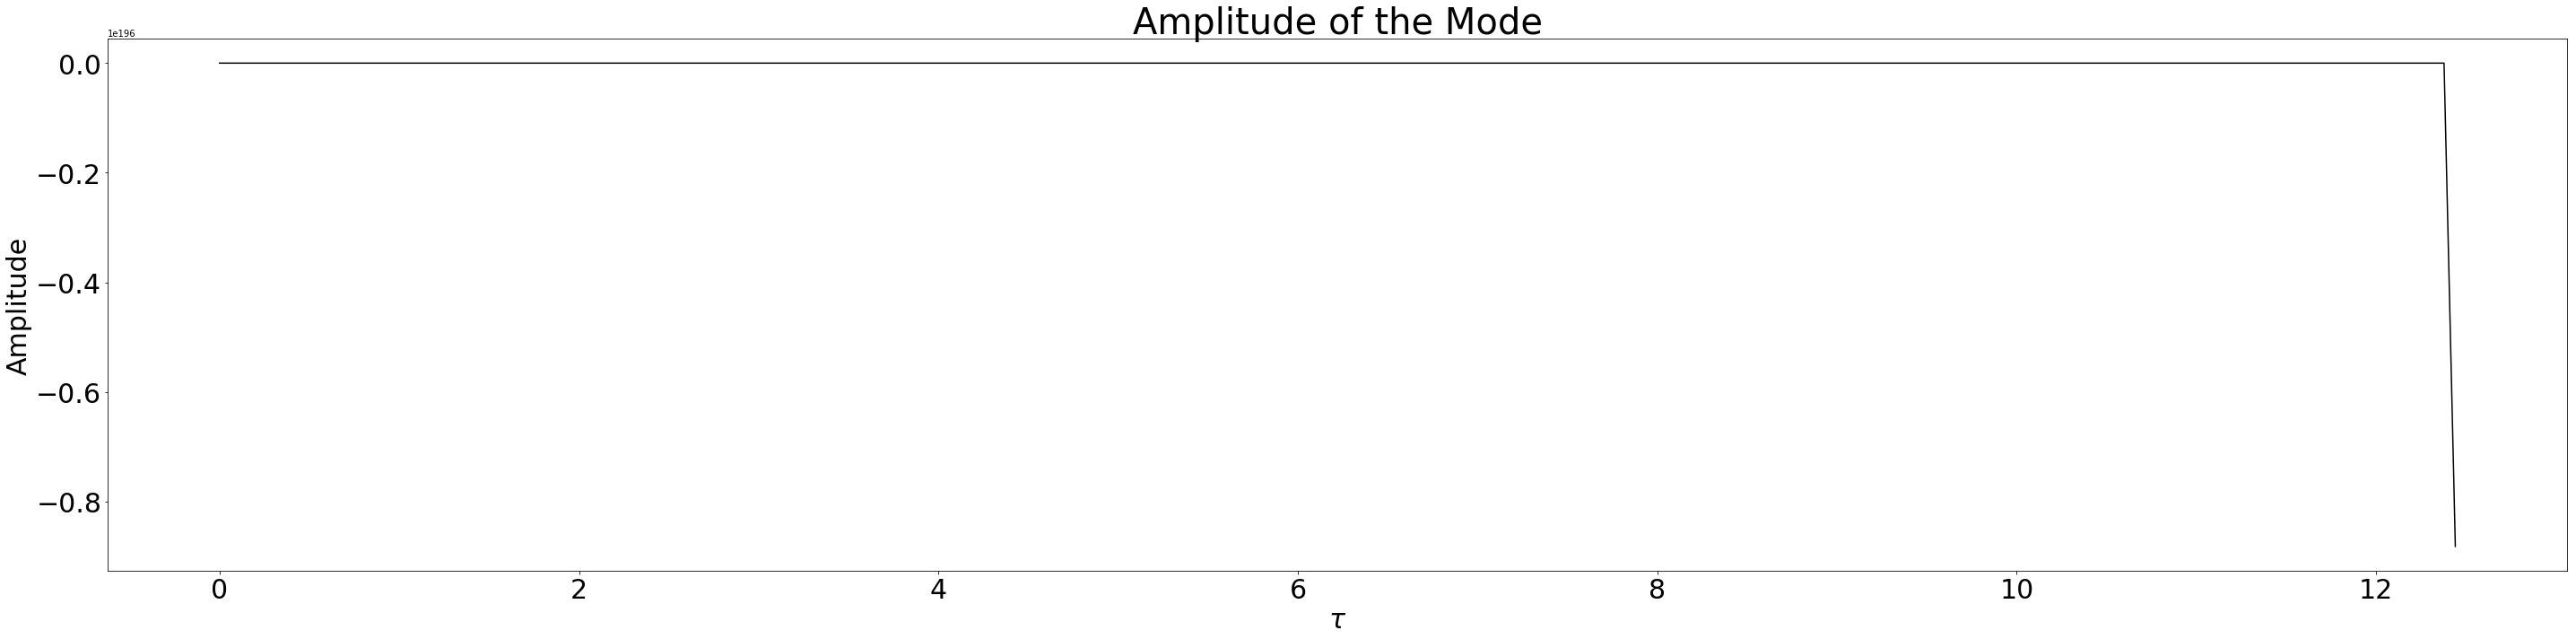

In [42]:
D = -0.9
N0 = 1

Amp, amptime = funNLAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT, N0, N1, D)

FunplotAmp(amptime, Amp)

### before blowout

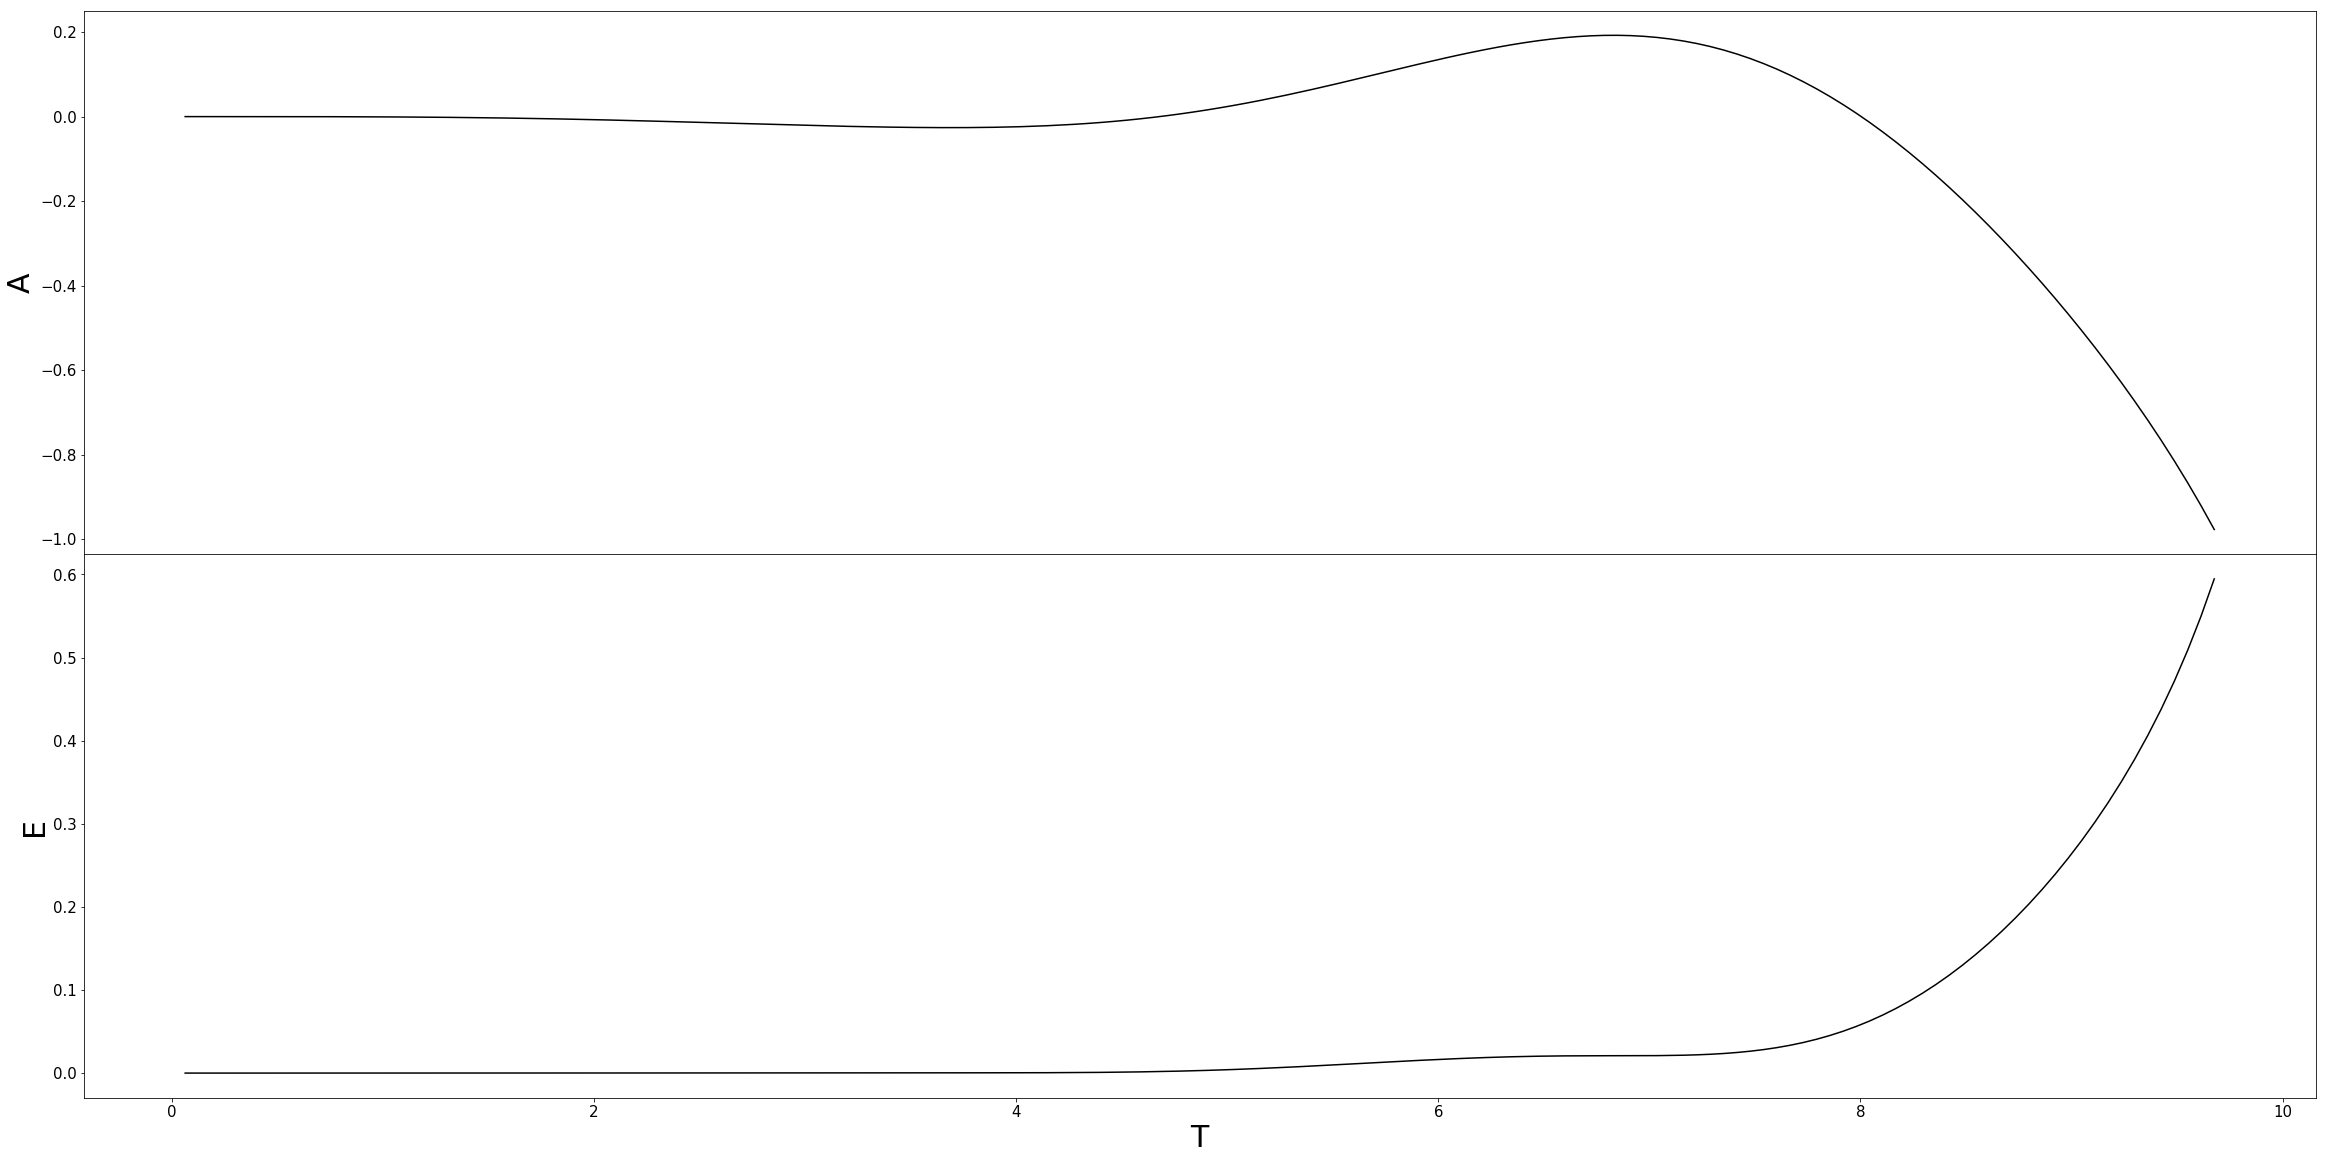

In [43]:
E, time, A, F2dAdT = funEnergy(Amp, amptime, N0, N1)

Eavg = split(E, 40)

Funplots(time, E, A)

In [44]:
print("E_max = ",  max(E))
print("1/(6N0^2) = " , 1/(6*N0**2))

print("\n")

print("D_0 = ", D)
print("2 N_0^2 <F_2 dA/dT >", 2 * N0**2 * Funavg(F2dAdT))

print("\n")

print("Tau_b = ", time[-1])
print("1/(N_0^2 etaMa^2) = ", 1 / (N0**2 * eta * Ma **2 ))
print("Tau_b = ", time[-1] * (N0**2 * eta * Ma **2 ) , "* 1/(N_0^2 etaMa^2)" )

E_max =  0.5946890968651113
1/(6N0^2) =  0.16666666666666666


D_0 =  -0.9
2 N_0^2 <F_2 dA/dT > -0.0026676210587805215


Tau_b =  9.676105373056535
1/(N_0^2 etaMa^2) =  99.99999999999999
Tau_b =  0.09676105373056537 * 1/(N_0^2 etaMa^2)
